### Step 4: continued analysis

Continuing step 4, we have seen in the last plot that the pricing strategy for the customers of class 1 and 2, we have aggregated them into a single class type of customer.
These are the snippets of code and results with plots.

In [1]:
import numpy as np

# Abstract-Super class of Learner
class Learner():
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.price = np.linspace(3.0, 15.0, self.n_arms) 
        self.t = 0  #Time 
        self.rewards_per_arm = x = [[] for i in range(n_arms)]
        self.collected_rewards = []
    
    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards.append(reward)

##################################   LEARNERS    ##################################
# Thompson-Sampling Learner

class TS_Learner(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        #Mean and Std
        self.normal_parameters = np.zeros((self.n_arms, 2))

    def pull_arm(self):
        if self.t < self.n_arms: return self.t
        return np.argmax(np.random.normal(self.normal_parameters[: , 0], self.normal_parameters[:, 1]))

    def update(self, pulled_arm, reward):
        self.t += 1
        times_pulled = max(1, len(self.rewards_per_arm[pulled_arm]))
        self.update_observations(pulled_arm, reward)
        #Empirical mean
        self.normal_parameters[pulled_arm, 0] = (self.normal_parameters[pulled_arm, 0] * (times_pulled - 1) + reward ) / times_pulled
        #Empirical std
        self.normal_parameters[pulled_arm, 1] = np.sqrt(sum((self.normal_parameters[pulled_arm, 0] - self.rewards_per_arm[pulled_arm])**2)/times_pulled)

# Upper-Confidence Bound Learner
class UCB1(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.confidence = np.zeros(n_arms)

    def pull_arm(self):
        if self.t < self.n_arms:
            return self.t 
        upper_bound = self.empirical_means + self.confidence
        return np.random.choice(np.where(upper_bound == upper_bound.max())[0])
    
    def update(self, pulled_arm, reward):
        self.t += 1
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards.append(reward)
        self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm] * (self.t-1) + reward)/self.t
        for a in range(self.n_arms):
            number_pulled = max(1, len(self.rewards_per_arm[a]) ) 
            self.confidence[a] = (2*np.log(self.t) /number_pulled)**0.5

### Main for the experiment for Step 4.2

In [2]:
from environment import Environment

env = Environment()
n_arms = 13
ucb1_learner_c0 = UCB1(n_arms = n_arms)
ucb1_learner_c12 = UCB1(n_arms = n_arms)
ts_learner_c0 = TS_Learner(n_arms = n_arms)
ts_learner_c12 = TS_Learner(n_arms = n_arms)

T = 365
opt_bids = [3.8622484787564275 , 2.1216094606111944,  2.347134281066495]
opt_price =6.321089806558111
regret_c0_ucb = []
regret_c12_ucb = []
regret_c0_ts = []
regret_c12_ts = []

# bids for this task has to be the optimal ones
bids = opt_bids 
prices = np.linspace(3.0, 15.0, n_arms)

price_ev_per_day_ucb = []
price_ev_per_day_ts = []

for day in range(T):
    #UCB1 learner
    price_c0_idx = ucb1_learner_c0.pull_arm()
    price_c0 = prices[price_c0_idx]
    price_c12_idx = ucb1_learner_c12.pull_arm()
    price_c12 = prices[price_c12_idx]
    
    reward_per_day = []
    price = [price_c0, price_c12]
    for i in range(len(price)):
        if i == 0 : 
            p = price[0]
            reward = env.round(bids, p)
            reward_per_day.append(reward[0])
        else :
            p = price[i]
            reward = env.round(bids, p)
            reward_per_day.append(reward[1]+reward[2])
            

    ucb1_learner_c0.update(price_c0_idx, reward_per_day[0])
    ucb1_learner_c12.update(price_c12_idx, reward_per_day[1])
    
    reward_optimal = env.round(opt_bids, opt_price, noise= False)
    regret_c0 = reward_optimal[0] - reward_per_day[0]
    regret_c12 = (reward_optimal[1]+reward_optimal[2]) - reward_per_day
    regret_c0_ucb.append(regret_c0)
    regret_c12_ucb.append(regret_c12)
    
    price_ev_per_day_ucb.append(price)

    #TS learner
    price_c0_idx = ts_learner_c0.pull_arm()
    price_c0 = prices[price_c0_idx]
    price_c12_idx = ts_learner_c12.pull_arm()
    price_c12 = prices[price_c12_idx]
    
    reward_per_day = []
    price = [price_c0, price_c12]
    for i in range(len(price)):
        if i == 0 : 
            p = price[i]
            reward = env.round(bids, p)
            reward_per_day.append(reward[0])
        else :    
            p = price[1]
            reward = env.round(bids, p)
            reward_per_day.append(reward[1]+reward[2])
        

    ts_learner_c0.update(price_c0_idx, reward_per_day[0])
    ts_learner_c12.update(price_c12_idx, reward_per_day[1])
    
    reward_optimal = env.round(opt_bids, opt_price, noise= False)
    regret_c0 = reward_optimal[0] - reward_per_day[0]
    regret_c12 = (reward_optimal[1]+reward_optimal[2]) - reward_per_day[1]
    regret_c0_ts.append(regret_c0)
    regret_c12_ts.append(regret_c12)
    
    price_ev_per_day_ts.append(price)

## Plots

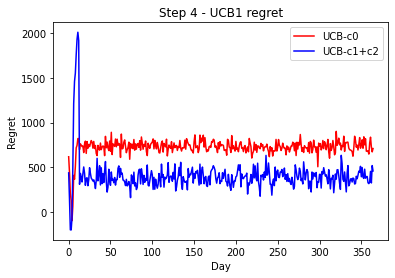

In [3]:
import matplotlib.pyplot as plt

plt.figure(0)
plt.xlabel("Day")
plt.ylabel("Regret")
plt.plot(regret_c0_ucb,'r', label="UCB-c0")
plt.plot(regret_c12_ucb, 'b', label="UCB-c1+c2")
plt.title("Step 4 - UCB1 regret")
plt.legend()
plt.show()

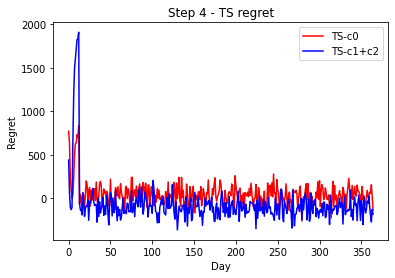

In [4]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.xlabel("Day")
plt.ylabel("Regret")
plt.plot(regret_c0_ts,'r', label="TS-c0")
plt.plot(regret_c12_ts, 'b', label="TS-c1+c2")
plt.title("Step 4 - TS regret")
plt.legend()
plt.show()


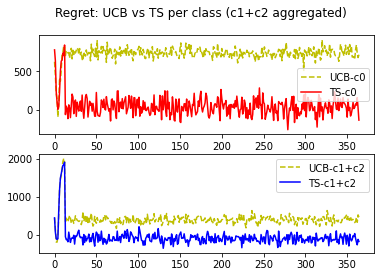

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
fig.suptitle('Regret: UCB vs TS per class (c1+c2 aggregated)')
axs[0].plot(regret_c0_ucb,'y', label="UCB-c0", linestyle="dashed")
axs[0].plot(regret_c0_ts,'r', label="TS-c0")
axs[0].legend()
axs[1].plot(regret_c12_ucb,'y', label="UCB-c1+c2", linestyle="dashed")
axs[1].plot(regret_c12_ts,'b', label="TS-c1+c2")
axs[1].legend()

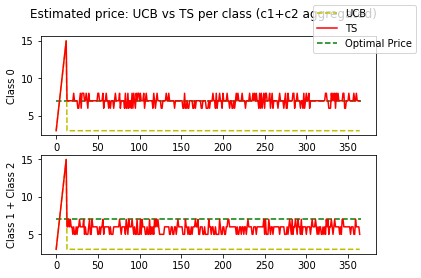

In [6]:
import matplotlib.pyplot as plt

YY_ucb = np.array(price_ev_per_day_ucb) 
YY_ts = np.array(price_ev_per_day_ts)
fig, axs = plt.subplots(2)
fig.suptitle('Estimated price: UCB vs TS per class (c1+c2 aggregated)')
axs[0].plot(YY_ucb[:,0],'y', linestyle="dashed")
axs[0].plot(YY_ts[:,0],'r')
axs[0].hlines(opt_price, 0, 365, 'g', linestyles='dashed')
axs[0].set(ylabel="Class 0")
axs[1].plot(YY_ucb[:,1],'y', linestyle="dashed")
axs[1].plot(YY_ts[:,1],'r')
axs[1].hlines(opt_price, 0, 365, 'g', linestyles='dashed')
axs[1].set(ylabel="Class 1 + Class 2")
fig.legend(["UCB","TS","Optimal Price"])